This notebook expects the Jupyter server serving from the same directory as this notebook is saved. Some relative paths might get broken if this is not the case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from qmc import *
from functions import bootstrap, blocking
figsize = (8, 8)
axis_fontsize = 26
title_fontsize = 20
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex = True)

/Users/bendik/drive/uio/10.semester/fys4411/projects/python /Users/bendik/drive/uio/10.semester/fys4411/projects /Users/bendik/drive/uio/10.semester/fys4411/projects/include /var/folders/69/n7l285595sz0cdm799b9lnfm0000gn/T/qmco8xwx6vt
Found libraries: ['/var/folders/69/n7l285595sz0cdm799b9lnfm0000gn/T/qmco8xwx6vt/libengine.dylib']
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/hamiltonian.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/prettyprint.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/rbm.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/combinedcalculator.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/vector.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/system.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/wavefunction.hpp
Loading /Users/bendik/drive/uio/10.semester/fys4411/projects/include/vmc.hpp
Loadi

# Utility Functions

In [2]:
def cpp_class_name(obj):
    name = repr(obj)
    return re.match("^.*gbl\.(\w+)\s", repr(name)).group(1)

def training_plot(target, rbm, H, sampler, iters, samples, lr=0.01, gamma=0, optimizer=None, saveas=None, verbose=False, plot_points=100, return_E=False):
    def eval():
        return abs(H.local_energy(sampler.next_configuration(), rbm) - target)
    
    if optimizer is None:
        optimizer = SgdOptimizer(lr)
    
    E = [sum(eval() for _ in range(samples)) / samples]
    param = [vector_to_array(rbm.get_parameters())]
    rounds_per_iteration = max(1, iters // plot_points)
    for i in range(min(iters, plot_points)):
        rbm.train(H, sampler, rounds_per_iteration, samples, optimizer, gamma, False)
        E.append(sum(eval() for _ in range(samples)) / samples)
        if verbose:
            print('E =', E[-1], flush=True)
        param.append(vector_to_array(rbm.get_parameters()))
    
    param = np.asarray(param)
    
    if return_E:
        return E
    
    fig, ax = plt.subplots(sharex=True, nrows=2, ncols=1, figsize=figsize)
    ax[0].semilogy(E, label=r'$\langle E_L\rangle$')
    ax[0].set_ylabel(r'$\langle E_L\rangle$ [a.u.]', fontsize=axis_fontsize-5)
    for i in range(rbm.get_parameters().size()):
        ax[1].plot(param[:,i], label=r'$\alpha_{%d}$' % i)
    ax[1].set_xlabel('Training iterations (x{})'.format(rounds_per_iteration), fontsize=axis_fontsize-5)
    plt.legend(fontsize=title_fontsize-5)
    
    if saveas:
        plt.savefig(saveas)

def multiplot(target, rbms, H, samplers, optimizers, iters, samples, gamma=0, 
              saveas=None, verbose=False, labels=None, zip_sampler_rbm_and_optimizer=False, logplot=True):
    initial_params = array_to_vector(vector_to_array(rbms[0].get_parameters()))
    fig, ax = plt.subplots(figsize=figsize)
    
    if zip_sampler_rbm_and_optimizer:
        for rbm, sampler, optimizer in zip(rbms, samplers, optimizers):
            E = training_plot(target, rbm, H, sampler, iters, samples, 
                              gamma=gamma, optimizer=optimizer, return_E=True, verbose=verbose)
            if logplot:
                ax.semilogy(E)
            else:
                ax.plot(E)
    else:
        for rbm, sampler in zip(rbms, samplers):
            for optimizer in optimizers:
                rbm.set_parameters(initial_params)
                E = training_plot(target, rbm, H, sampler, iters, samples, 
                                  gamma=gamma, optimizer=optimizer, return_E=True, verbose=verbose)
                if logplot:
                    ax.semilogy(E)
                else:
                    ax.plot(E)

    ax.set_ylabel(r'Error in $\langle E_L\rangle$ [a.u.]', fontsize=axis_fontsize-5)
    ax.set_xlabel(r'Training iterations (percent of training)', fontsize=axis_fontsize-5)
    if labels:
        plt.legend(labels, fontsize=title_fontsize-5)
    if saveas:
        plt.savefig(saveas)
            
def onebodydensity_plot(H, sampler, n_bins, max_radius, samples, 
                        saveas=None, fig_ax=None, plot_exact=True, label='RBM'):
    rho = vector_to_array(H.onebodydensity(sampler, n_bins, max_radius, samples))
    r = np.linspace(0, max_radius, len(rho))

    rho /= np.trapz(rho, x=r)
    
    exact = np.exp(- r**2)
    exact = exact / np.trapz(exact, x=r)

    if fig_ax:
        fig, ax = fig_ax
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    if plot_exact:
        ax.plot(r, exact, label='Exact')
    ax.plot(r, rho, label=label)
    ax.set_xlabel(r'$r/r_0$', fontsize=axis_fontsize-5)
    ax.set_ylabel(r'$\rho_i$', fontsize=axis_fontsize-5)
    plt.legend(fontsize=title_fontsize-5)
    
    if saveas:
        plt.savefig(saveas)
        
    return fig, ax

# One electron, 1D

In [3]:
P, D = 1, 1
M = P * D
N = 2
sigma2 = 1
system = System(P, D)
H = RBMHarmonicOscillatorHamiltonian()

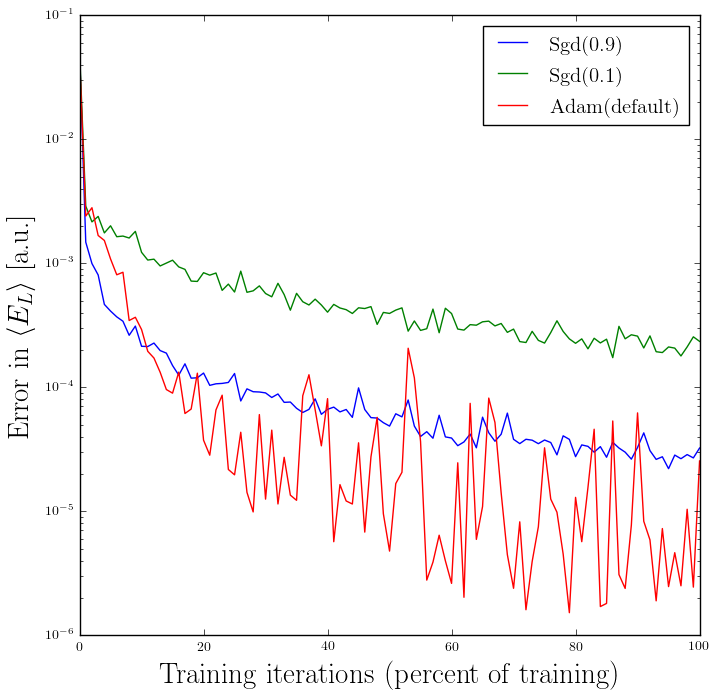

In [4]:
rand_gen.seed(123)
rbms = [RBMWavefunction(M, N, sigma2)]
samplers = [ImportanceSampler(system, rbms[0], 0.5)]
optimizers = [SgdOptimizer(0.9), SgdOptimizer(0.1), AdamOptimizer(rbms[0].get_parameters().size())]
labels = 'Sgd(0.9)', 'Sgd(0.1)', 'Adam(default)'
multiplot(0.5, rbms, H, samplers, optimizers, 60000, 100, labels=labels, saveas='../results/learning-optimizers.png')

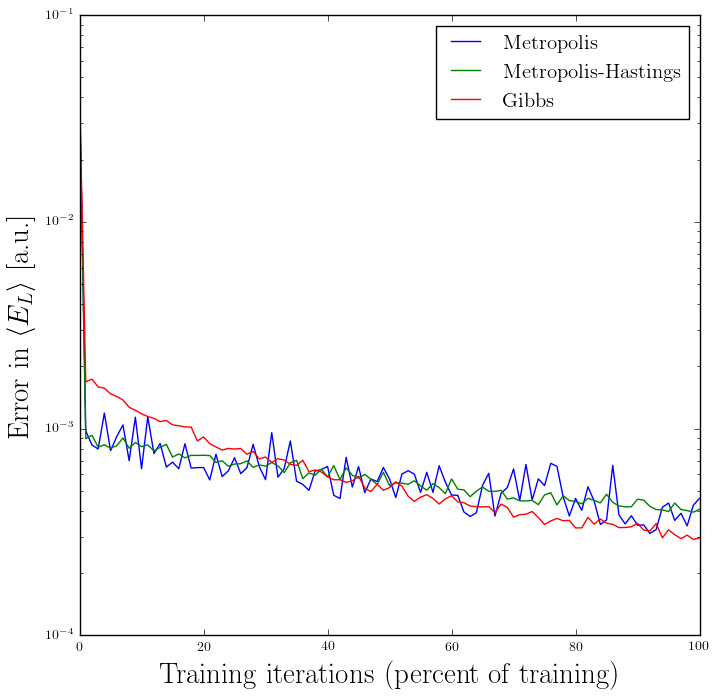

In [5]:
rand_gen.seed(123)
rbms = [RBMWavefunction(M, N, sigma2), RBMWavefunction(M, N, sigma2), RBMWavefunction(M, N, RBMWavefunction.GIBBS_FACTOR * sigma2, RBMWavefunction.GIBBS_FACTOR)]
samplers = [MetropolisSampler(system, rbms[0], 0.5), ImportanceSampler(system, rbms[1], 0.5), GibbsSampler(system, rbms[2])]
optimizers = [SgdOptimizer(0.1)]
labels = 'Metropolis', 'Metropolis-Hastings', 'Gibbs'
multiplot(0.5, rbms, H, samplers, optimizers, 20000, 1000, labels=labels, saveas='../results/learning-samplers.png')

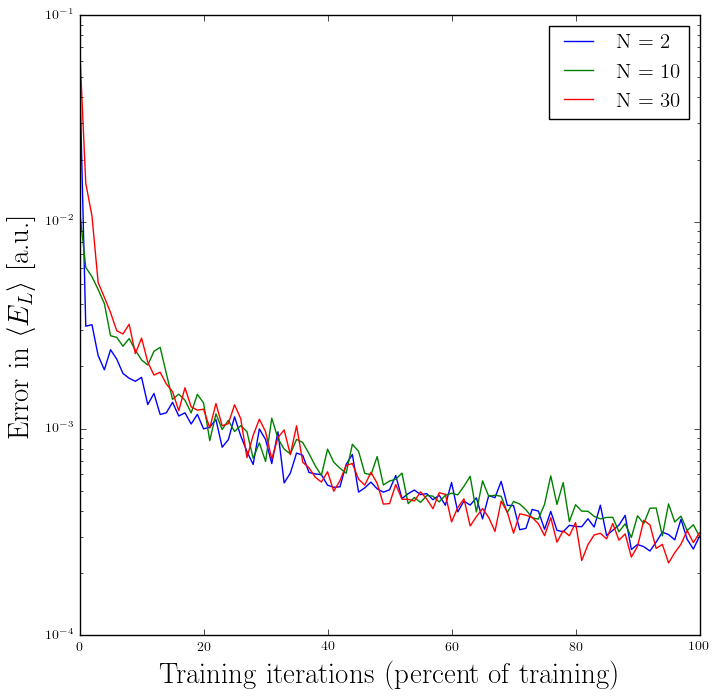

In [6]:
rand_gen.seed(123)
rbms = [RBMWavefunction(M, 2, sigma2), RBMWavefunction(M, 10, sigma2), RBMWavefunction(M, 30, sigma2)]
samplers = [ImportanceSampler(system, rbm, 0.5) for rbm in rbms]
optimizers = [SgdOptimizer(0.1) for rbm in rbms]
labels = ['N = %d' % rbm._N for rbm in rbms]
multiplot(0.5, rbms, H, samplers, optimizers, 40000, 100, 
          labels=labels, saveas='../results/learning-N-variants.png',
          zip_sampler_rbm_and_optimizer=True)

# Standard Metropolis

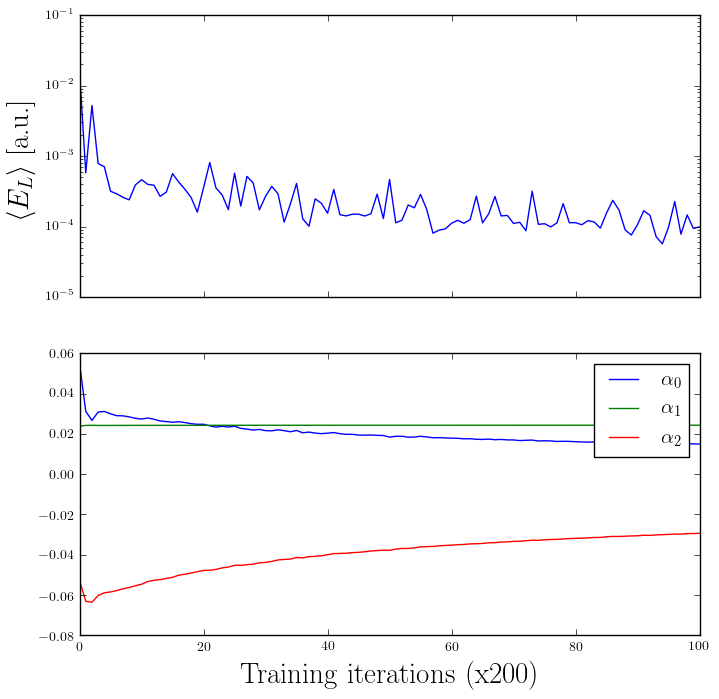

In [81]:
rand_gen.seed(123)
rbm = RBMWavefunction(M, N, sigma2)
initial_params = array_to_vector(vector_to_array(rbm.get_parameters()))  # Copy for later use.
sampler = MetropolisSampler(system, rbm, 0.5)
training_plot(0.5, rbm, H, sampler, 20000, 100, 0.9, saveas='../results/rbm-1d-1p-training-lr-09-metro.png', plot_points=100)

In [7]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

(0.49999985156653198, 6.1471032915369294e-08, 1.9788163109680766e-06)

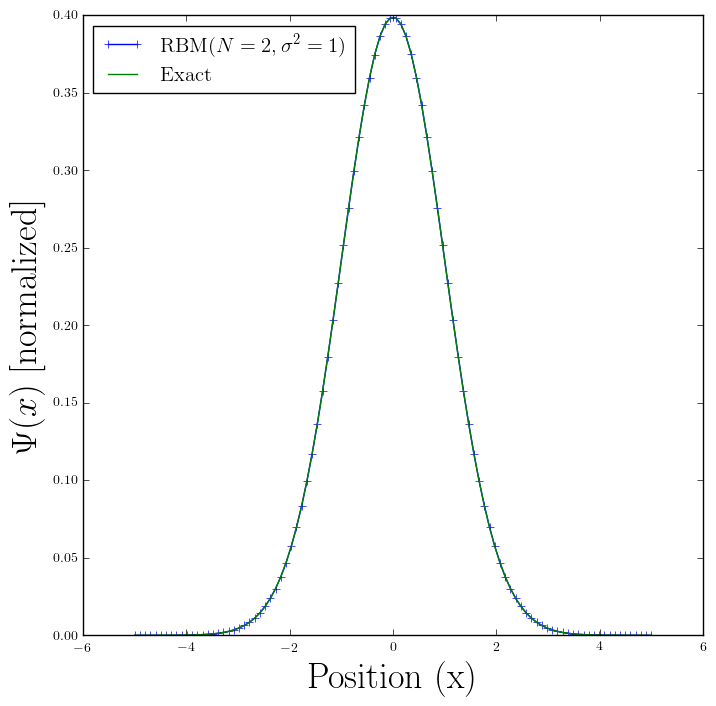

In [8]:
x_array = np.linspace(-5, 5, 100)
s_array = np.asarray([array_to_system(np.array([[x]])) for x in x_array])

learned = np.asarray([rbm(s_i) for s_i in s_array])
learned_norm = learned / np.trapz(learned, x=x_array)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(x_array, learned_norm, '-+', label='RBM($N={}, \sigma^2 = {}$)'.format(N, sigma2))
ax.plot(x_array, (2*np.pi)**(-0.5) * np.exp(-0.5 * x_array**2), label='Exact')
ax.set_xlabel('Position (x)', fontsize=axis_fontsize)
ax.set_ylabel(r'$\Psi(x)$ [normalized]', fontsize=axis_fontsize)
plt.legend(fontsize=title_fontsize-5, loc='upper left')
plt.savefig('../results/rbm-1d-1p.png')

## Importance Sampling

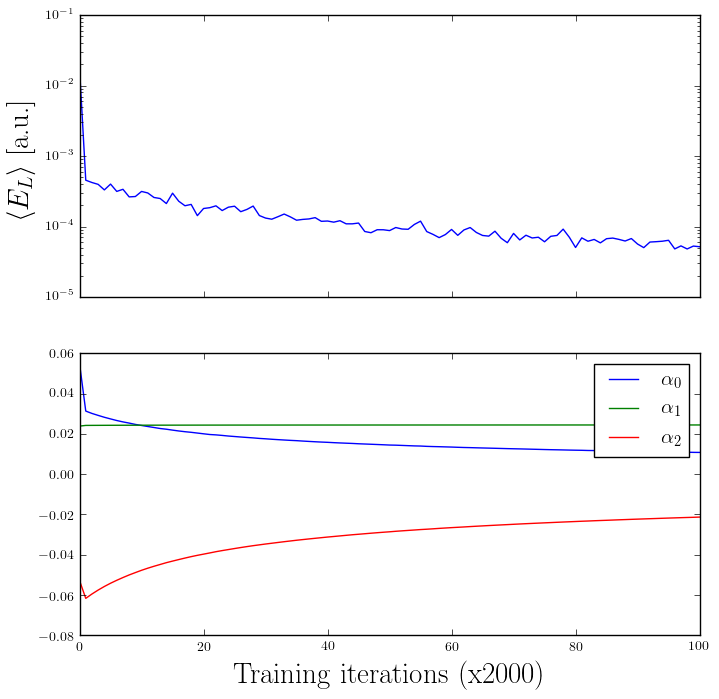

In [82]:
rbm = RBMWavefunction(M, N, sigma2)
rbm.set_parameters(initial_params)
sampler = ImportanceSampler(system, rbm, 0.5)
optimizer = SgdOptimizer(0.1)#AdamOptimizer(rbm.get_parameters().size())
training_plot(0.5, rbm, H, sampler, 200000, 100, optimizer=optimizer, saveas='../results/rbm-1d-1p-training-lr-09-imp.png')

In [70]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

(0.49999985871297487, 9.4397326667140483e-09, 1.2688504638162717e-07)

## Gibbs Sampling

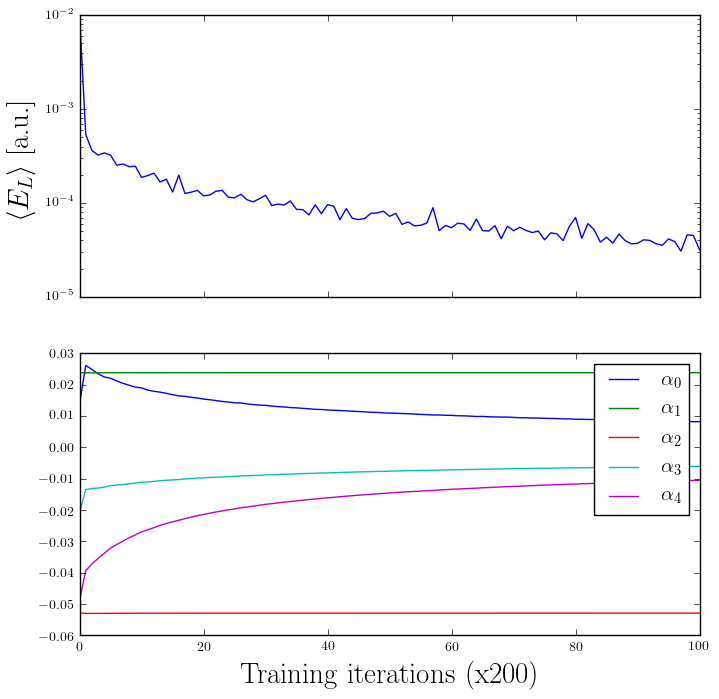

In [19]:
rbm = RBMWavefunction(M, N, 0.5, RBMWavefunction.GIBBS_FACTOR)
rbm.set_parameters(initial_params)
sampler = GibbsSampler(system, rbm)
training_plot(0.5, rbm, H, sampler, 20000, 100, 0.9, 0.0, saveas='../results/rbm-1d-1p-training-lr-09-gibbs.png')

In [20]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

(0.49999999815673413, 2.737920340631941e-09, 5.188610985347837e-08)

# More dimensions, more particles

In [20]:
P, D = 2, 2
M = P * D
N = M - 2
sigma2 = 1
system = System(P, D)
H = RBMHarmonicOscillatorHamiltonian()

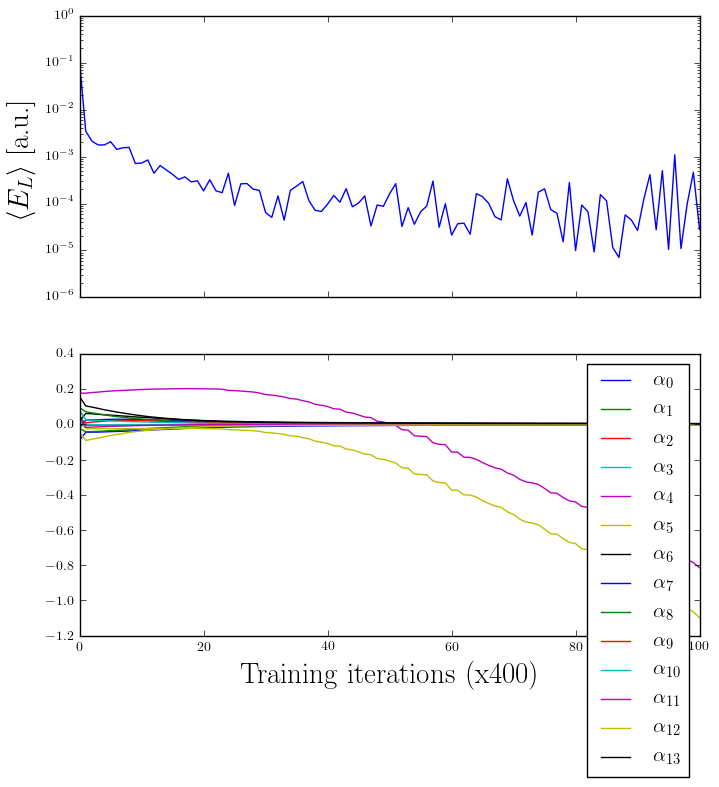

In [21]:
rbm = RBMWavefunction(M, N, sigma2)
sampler = ImportanceSampler(system, rbm, 0.5)
optimizer = AdamOptimizer(rbm.get_parameters().size())
training_plot(2, rbm, H, sampler, 40000, 100, optimizer=optimizer, saveas='../results/rbm-{}d-{}p-training-lr-01-imp.png'.format(D, P))

In [22]:
E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
np.mean(E), np.var(E), blocking(E)

(2.0000000269435545, 9.4536550533605655e-10, 7.127292578413986e-08)

In [17]:
H.mean_distance(sampler, 2**20)

1.2557944397547751

In [18]:
viral = np.empty((2**20, 2))
for i in range(viral.shape[0]):
    s = sampler.next_configuration()
    viral[i, 0] = H.kinetic_energy(s, rbm)
    viral[i, 1] = H.external_potential(s) + H.internal_potential(s)
K, V = viral.T
np.mean(K), np.mean(V)

(1.0016368268467246, 0.99836303400854498)

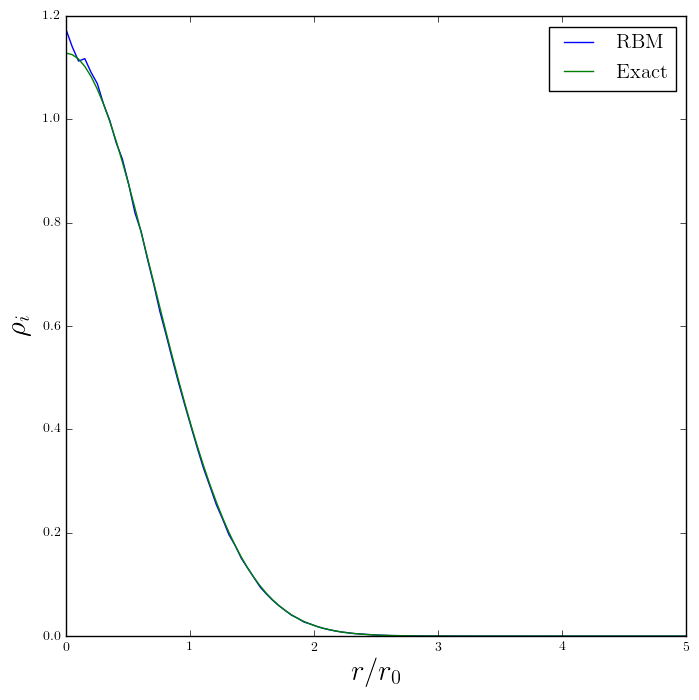

In [19]:
onebodydensity_plot(H, sampler, 100, 5, 2**20, saveas='../results/P2-D2-onebody.png')

# Interaction

In [3]:
rand_gen.seed(1234)
P, D = 2, 2
M = P * D
N = 1
sigma2 = 1
system = System(P, D)
H = RBMInteractingHamiltonian()

## Exploring N's

In [7]:
rand_gen.seed(1234)
rhos = [0.25, 0.5, 1, 2, 3]
rbms = [RBMWavefunction(M, int(M * rho), sigma2) for rho in rhos]
samplers = [ImportanceSampler(system, rbm, 0.5) for rbm in rbms]
optimizers = [AdamOptimizer(rbm.get_parameters().size()) for rbm in rbms]

for rbm, sampler, optimizer in zip(rbms, samplers, optimizers):
    print('Training N = {} ... '.format(rbm._N), end='', flush=True)
    rbm.train(H, sampler, 10000, 1000, optimizer, 0, False)
    print('Done!', flush=True)
    E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
    print('E = {}, Var = {}, SE = {}'.format(np.mean(E), np.var(E), blocking(E)), flush=True)

Training N = 1 ... Done!
E = 3.148114050294898, Var = 5.0473465509371085, SE = 0.002867680466342137
Training N = 2 ... Done!
E = 3.0765143388648033, Var = 2.3401605222803328, SE = 0.0017484393312402725
Training N = 4 ... Done!
E = 3.0796901607619596, Var = 3.0194478763624404, SE = 0.001872431852518284
Training N = 8 ... Done!
E = 3.08267252391181, Var = 3.7912639855704082, SE = 0.0020507592070031474
Training N = 12 ... Done!
E = 3.0856212889452777, Var = 3.7647337762414788, SE = 0.002060846607125286


### Exploring regularization

In [12]:
rand_gen.seed(1234)
rhos = [0.5, 1]
rbms = [RBMWavefunction(M, int(M * rho), sigma2) for rho in rhos]
samplers = [ImportanceSampler(system, rbm, 0.5) for rbm in rbms]
optimizers = [AdamOptimizer(rbm.get_parameters().size()) for rbm in rbms]

for rbm, sampler, optimizer in zip(rbms, samplers, optimizers):
    for gamma in [0, 0.001, 0.0001, 0.00001]:
        print('Training N = {} ... '.format(rbm._N), end='', flush=True)
        rbm.train(H, sampler, 10000, 1000, optimizer, gamma, False)
        print('Done!', flush=True)
        E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(2**20)])
        print('E = {}, Var = {}, SE = {}'.format(np.mean(E), np.var(E), blocking(E)), flush=True)

Training N = 2 ... Done!
E = 3.076101859219082, Var = 2.832545672608078, SE = 0.0017778830904523985
Training N = 2 ... Done!
E = 3.248968434983139, Var = 5.984232999268931, SE = 0.0030068435663223353
Training N = 2 ... Done!
E = 3.2537009983273117, Var = 4.875994715969571, SE = 0.002624534727444647
Training N = 2 ... Done!
E = 3.252427821425896, Var = 5.352408828417619, SE = 0.0027531400147348603
Training N = 4 ... Done!
E = 3.080892880863403, Var = 2.7292321350029662, SE = 0.0018027657984936436
Training N = 4 ... Done!
E = 3.253400468750004, Var = 6.388607930106395, SE = 0.0029249256736709607
Training N = 4 ... Done!
E = 3.24880184754143, Var = 3.947860929466623, SE = 0.002418510260617642
Training N = 4 ... Done!
E = 3.250367596184877, Var = 5.301990561045776, SE = 0.002747198846500351


## N = 2

In [24]:
rand_gen.seed(1234)
rbm_best = RBMWavefunction(M, 2, sigma2)
sampler_best = ImportanceSampler(system, rbm_best, 0.1)
optimizer = AdamOptimizer(rbm_best.get_parameters().size())

rbm_best.train(H, sampler_best, 20000, 1000, optimizer, 0, False)

In [26]:
E = np.asarray([H.local_energy(sampler_best.next_configuration(), rbm_best) for _ in range(2**22)])
np.mean(E), np.var(E), blocking(E)

(3.0787283818208562, 3.1694945017693916, 0.0012169412102211615)

In [27]:
H.mean_distance(sampler_best, 2**22)

1.6524033456628535

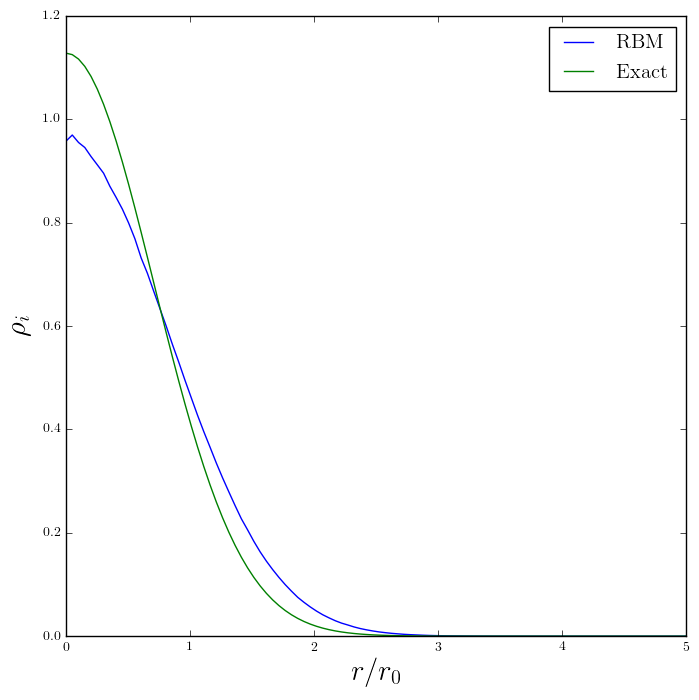

In [28]:
onebodydensity_plot(H, sampler_best, 100, 5, 2**22, saveas='../results/onebody-interacting-N2.png')

In [29]:
viral = np.empty((2**22, 2))
for i in range(viral.shape[0]):
    s = sampler_best.next_configuration()
    viral[i, 0] = H.kinetic_energy(s, rbm_best)
    viral[i, 1] = H.external_potential(s) + H.internal_potential(s)
K, V = viral.T
np.mean(K), np.mean(V)

(0.79836032841772875, 2.2794296834031833)

## Varying $\omega$

### No interaction

Blocking warning: Blocked until stopped. Use more data if var != 0.
omega=0.01 : <E> = 0.020000000000000014, SE = 0.0, <r_12> = 12.337171193094866, <K> = 0.010208219021850077, <V> = 0.00979178097814808, <K>_virial = 0.00979178097814808


/Users/bendik/drive/uio/10.semester/fys4411/projects/python/functions.py:247: RuntimeWarning: divide by zero encountered in true_divide
  M = (np.cumsum(((gamma / s)**2 * 2**np.arange(1, d + 1)[::-1])[::-1] ))[::-1]


Blocking warning: Blocked until stopped. Use more data if var != 0.
omega=0.05 : <E> = 0.09999999999999978, SE = 0.0, <r_12> = 5.680062891134128, <K> = 0.05075145435228474, <V> = 0.04924854564771572, <K>_virial = 0.04924854564771572
Blocking warning: Blocked until stopped. Use more data if var != 0.
omega=0.1 : <E> = 0.19999999999999957, SE = 0.0, <r_12> = 3.9746152864418476, <K> = 0.0998552540189473, <V> = 0.10014474598104695, <K>_virial = 0.10014474598104695
Blocking warning: Blocked until stopped. Use more data if var != 0.
omega=0.5 : <E> = 1.0, SE = 0.0, <r_12> = 1.7692775877187106, <K> = 0.4977221392402451, <V> = 0.5022778607597476, <K>_virial = 0.5022778607597476


/Users/bendik/drive/uio/10.semester/fys4411/projects/python/functions.py:247: RuntimeWarning: invalid value encountered in true_divide
  M = (np.cumsum(((gamma / s)**2 * 2**np.arange(1, d + 1)[::-1])[::-1] ))[::-1]


Blocking warning: Blocked until stopped. Use more data if var != 0.
omega=1 : <E> = 2.0, SE = 0.0, <r_12> = 1.2504216014490297, <K> = 0.9978518621696488, <V> = 1.0021481378303492, <K>_virial = 1.0021481378303492


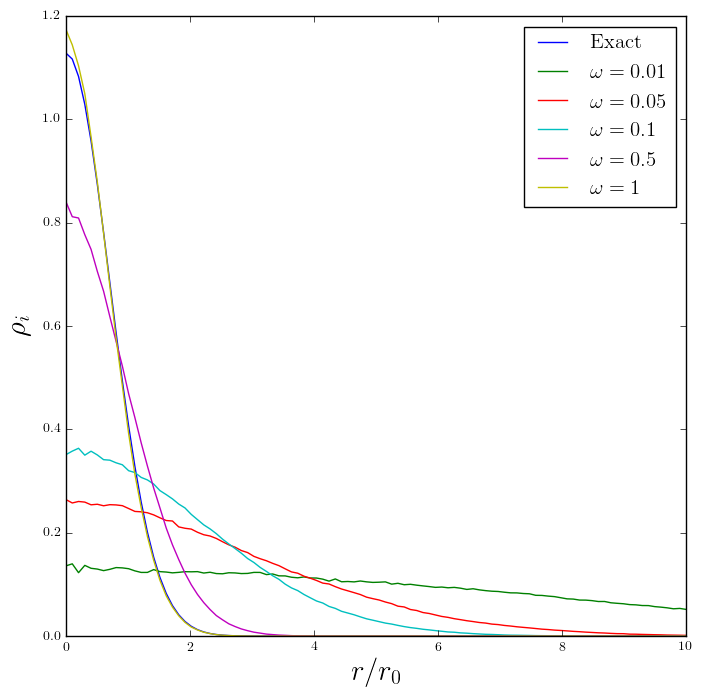

In [4]:
rand_gen.seed(1234)
eval_samples = 2**20
fig, ax = plt.subplots(figsize=figsize)
for omega in [0.01, 0.05, 0.1, 0.5, 1]:
    H = RBMHarmonicOscillatorHamiltonian(omega)
    rbm = RBMWavefunction(M, 1, 1 / omega)
    sampler = ImportanceSampler(system, rbm, 0.1)
    rbm.set_parameters(Vector(rbm.get_parameters().size()))  # Skip training now,  use ideal.
    
    E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(eval_samples)])
    r_mean = H.mean_distance(sampler, eval_samples)
    viral = np.empty((eval_samples, 3))
    for i in range(viral.shape[0]):
        s = sampler.next_configuration()
        viral[i, 0] = H.kinetic_energy(s, rbm)
        viral[i, 1] = H.external_potential(s) + H.internal_potential(s)
        viral[i, 2] = H.external_potential(s) - 0.5 * H.internal_potential(s)
    K, V, K_viral = np.mean(viral, axis=0)
    print('omega={} : <E> = {}, SE = {}, <r_12> = {}, <K> = {}, <V> = {}, <K>_virial = {}'.format(omega,
                                                                                 np.mean(E), 
                                                                                 blocking(E), 
                                                                                 r_mean,
                                                                                 K,
                                                                                 V,K_viral), 
          flush=True)
    onebodydensity_plot(H, sampler, 100, 10, eval_samples, 
                        fig_ax=(fig, ax), plot_exact=omega == 0.01, 
                        label=r'$\omega = {}$'.format(omega))
plt.savefig('../results/onebody-omegas-ideal.png')

### With interaction

omega=0.01 : <E> = 0.1445300984719826, SE = 0.0016594499475353491, <r_12> = 12.643974561749573, <K> = 0.00985577708993366, <V> = 0.13265367541149856, <K>_virial = -0.050973307110772324
omega=0.05 : <E> = 0.27761102556212386, SE = 0.0005420578872155698, <r_12> = 11.307481396064057, <K> = 0.05075062274300757, <V> = 0.22681951575243367, <K>_virial = 0.061122707063968336
omega=0.1 : <E> = 0.4855512221068041, SE = 0.0006783812588228887, <r_12> = 7.147548107052745, <K> = 0.09940602487874298, <V> = 0.38566779393052514, <K>_virial = 0.10600450513576362
omega=0.5 : <E> = 1.720729378773771, SE = 0.000991940530771009, <r_12> = 2.5477965406417473, <K> = 0.3809365888983305, <V> = 1.339580731684349, <K>_virial = 0.4556784884173183
omega=1 : <E> = 3.0769297506302564, SE = 0.0011413625573135848, <r_12> = 1.653226361948856, <K> = 0.7995876347942019, <V> = 2.277450556941172, <K>_virial = 0.8876958519816714


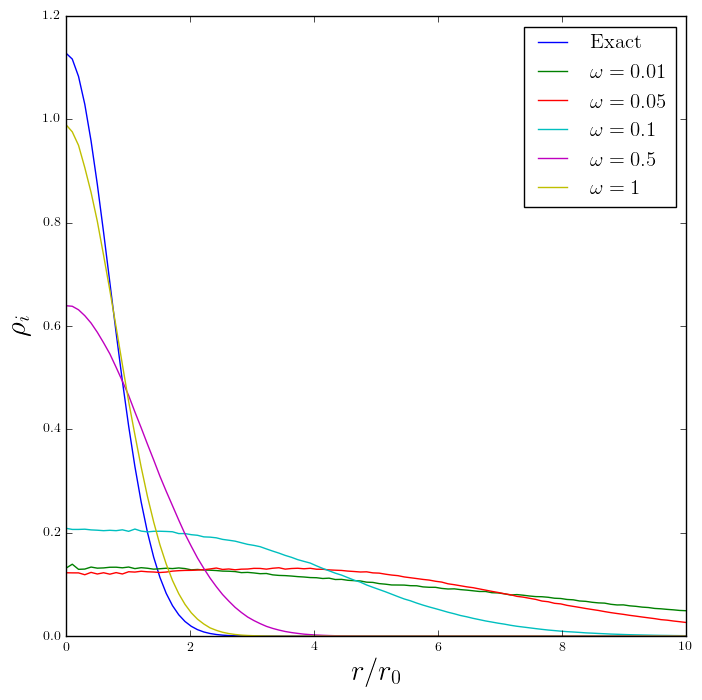

In [5]:
rand_gen.seed(1234)
eval_samples = 2**22
fig, ax = plt.subplots(figsize=figsize)
for omega in [0.01, 0.05, 0.1, 0.5, 1]:
    H = RBMInteractingHamiltonian(omega)
    rbm = RBMWavefunction(M, 2, 1 / omega)
    sampler = ImportanceSampler(system, rbm, 0.1)
    optimizer = AdamOptimizer(rbm.get_parameters().size())
    rbm.train(H, sampler, 20000, 1000, optimizer, 0, False)
    
    E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(eval_samples)])
    r_mean = H.mean_distance(sampler, eval_samples)
    viral = np.empty((eval_samples, 3))
    for i in range(viral.shape[0]):
        s = sampler.next_configuration()
        viral[i, 0] = H.kinetic_energy(s, rbm)
        viral[i, 1] = H.external_potential(s) + H.internal_potential(s)
        viral[i, 2] = H.external_potential(s) - 0.5 * H.internal_potential(s)
    K, V, K_viral = np.mean(viral, axis=0)
    print('omega={} : <E> = {}, SE = {}, <r_12> = {}, <K> = {}, <V> = {}, <K>_virial = {}'.format(omega,
                                                                                 np.mean(E), 
                                                                                 blocking(E), 
                                                                                 r_mean,
                                                                                 K,
                                                                                 V, K_viral), 
          flush=True)
    onebodydensity_plot(H, sampler, 100, 10, eval_samples, 
                        fig_ax=(fig, ax), plot_exact=omega == 0.01, 
                        label=r'$\omega = {}$'.format(omega))
plt.savefig('../results/onebody-omegas-v2.png')

### N = 4

omega=0.01 : <E> = 0.144919676039547, SE = 0.0016807014512808165, <r_12> = 12.537649374738226, <K> = 0.009860109108040775, <V> = 0.13395642862600515, <K>_virial = -0.05166586509745447
omega=0.05 : <E> = 0.2779866927181121, SE = 0.0005463656722987396, <r_12> = 11.32104152569703, <K> = 0.05064174618898617, <V> = 0.2264648083879958, <K>_virial = 0.06181041378974186
omega=0.1 : <E> = 0.48582915658578674, SE = 0.000676437876417674, <r_12> = 7.215745771874315, <K> = 0.09910257814799817, <V> = 0.3859747400673553, <K>_virial = 0.10968078384527731
omega=0.5 : <E> = 1.7277247263483586, SE = 0.0010661584723271192, <r_12> = 2.530736365292979, <K> = 0.3785038405569982, <V> = 1.3489503987080893, <K>_virial = 0.44729675841198857
omega=1 : <E> = 3.079149249443841, SE = 0.0011930401027766607, <r_12> = 1.6498524288565477, <K> = 0.7988554696253113, <V> = 2.282177869788218, <K>_virial = 0.8830907954298433


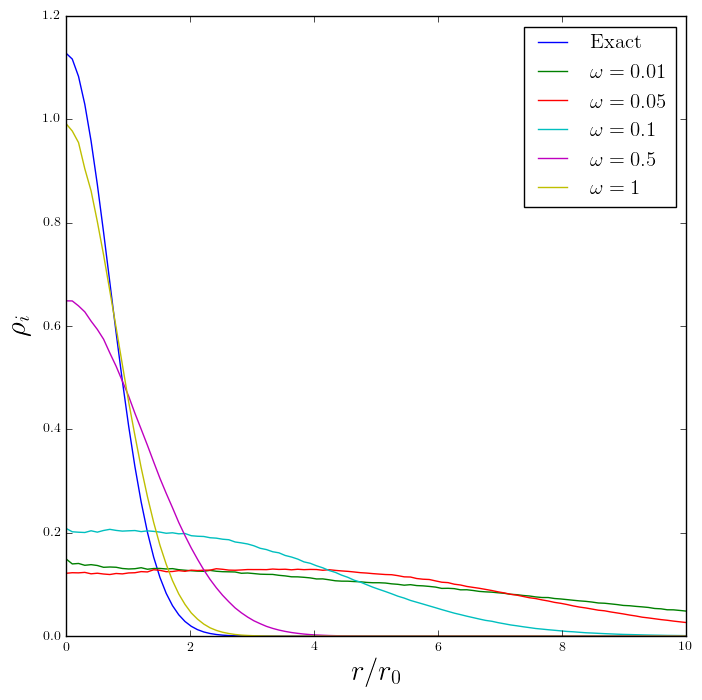

In [6]:
rand_gen.seed(1234)
eval_samples = 2**22
fig, ax = plt.subplots(figsize=figsize)
for omega in [0.01, 0.05, 0.1, 0.5, 1]:
    H = RBMInteractingHamiltonian(omega)
    rbm = RBMWavefunction(M, 4, 1 / omega)
    sampler = ImportanceSampler(system, rbm, 0.1)
    optimizer = AdamOptimizer(rbm.get_parameters().size())
    rbm.train(H, sampler, 20000, 1000, optimizer, 0, False)
    
    E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(eval_samples)])
    r_mean = H.mean_distance(sampler, eval_samples)
    viral = np.empty((eval_samples, 3))
    for i in range(viral.shape[0]):
        s = sampler.next_configuration()
        viral[i, 0] = H.kinetic_energy(s, rbm)
        viral[i, 1] = H.external_potential(s) + H.internal_potential(s)
        viral[i, 2] = H.external_potential(s) - 0.5 * H.internal_potential(s)
    K, V, K_viral = np.mean(viral, axis=0)
    print('omega={} : <E> = {}, SE = {}, <r_12> = {}, <K> = {}, <V> = {}, <K>_virial = {}'.format(omega,
                                                                                 np.mean(E), 
                                                                                 blocking(E), 
                                                                                 r_mean,
                                                                                 K,
                                                                                 V,K_viral), 
          flush=True)
    onebodydensity_plot(H, sampler, 100, 10, eval_samples, 
                        fig_ax=(fig, ax), plot_exact=omega == 0.01, 
                        label=r'$\omega = {}$'.format(omega))
plt.savefig('../results/onebody-omegas-v2-N4.png')

### $\sigma^2 = 1$ for all $\omega$ 

omega=0.01 : <E> = 1.087581808105676, SE = 0.0014878737061693721, <r_12> = 12.084924314174922, <K> = 1.0002563644867573, <V> = 0.08706482072896943, <K>_virial = -0.037941392462006375
omega=0.05 : <E> = 1.0334738826273964, SE = 0.0012926131455823385, <r_12> = 6.456571581298486, <K> = 0.8332845006838677, <V> = 0.2005284183974653, <K>_virial = -0.05649589005245518
omega=0.1 : <E> = 1.0183107868274845, SE = 0.0011950334600357728, <r_12> = 5.503100488730244, <K> = 0.7288989851414914, <V> = 0.28858759161603986, <K>_virial = -0.00880174346320734
omega=0.5 : <E> = 1.8480647706937794, SE = 0.0011092877635548682, <r_12> = 2.3238242748041227, <K> = 0.7261357906089364, <V> = 1.1210503548302704, <K>_virial = 0.23281260906088772
omega=1 : <E> = 3.0778856847453016, SE = 0.001159522765143678, <r_12> = 1.654397506838671, <K> = 0.7987534174282972, <V> = 2.281003775670399, <K>_virial = 0.888544777492041


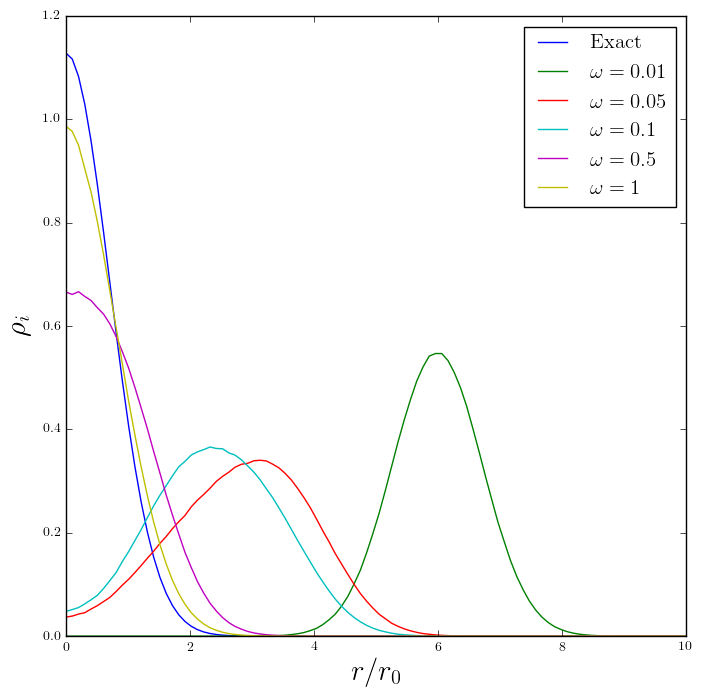

In [4]:
rand_gen.seed(1234)
eval_samples = 2**22
fig, ax = plt.subplots(figsize=figsize)
for omega in [0.01, 0.05, 0.1, 0.5, 1]:
    H = RBMInteractingHamiltonian(omega)
    rbm = RBMWavefunction(M, 2, 1)
    sampler = ImportanceSampler(system, rbm, 0.1)
    optimizer = AdamOptimizer(rbm.get_parameters().size())
    rbm.train(H, sampler, 20000, 1000, optimizer, 0, False)
    
    E = np.asarray([H.local_energy(sampler.next_configuration(), rbm) for _ in range(eval_samples)])
    r_mean = H.mean_distance(sampler, eval_samples)
    viral = np.empty((eval_samples, 3))
    for i in range(viral.shape[0]):
        s = sampler.next_configuration()
        viral[i, 0] = H.kinetic_energy(s, rbm)
        viral[i, 1] = H.external_potential(s) + H.internal_potential(s)
        viral[i, 2] = H.external_potential(s) - 0.5 * H.internal_potential(s)
    K, V, K_viral = np.mean(viral, axis=0)
    print('omega={} : <E> = {}, SE = {}, <r_12> = {}, <K> = {}, <V> = {}, <K>_virial = {}'.format(omega,
                                                                                 np.mean(E), 
                                                                                 blocking(E), 
                                                                                 r_mean,
                                                                                 K,
                                                                                 V,K_viral), 
          flush=True)
    onebodydensity_plot(H, sampler, 100, 10, eval_samples, 
                        fig_ax=(fig, ax), plot_exact=omega == 0.01, 
                        label=r'$\omega = {}$'.format(omega))
plt.savefig('../results/onebody-omegas-v2-sigma2-fixed.png')